<html>
<table width="100%" cellspacing="2" cellpadding="2" border="1">
<tbody>
<tr>
<td valign="center" align="center" width="45%"><img src="../media/Univ-Utah.jpeg"><br>
</td>
    <td valign="center" align="center" width="75%">
<h1 align="center"><font size="+1">University of Utah<br>Population Health Sciences<br>Data Science Workshop</font></h1></td>
<td valign="center" align="center" width="45%"><img
src="../media/U_Health_stacked_png_red.png" alt="Utah Health
Logo" width="128" height="134"><br>
</td>
</tr>
</tbody>
</table>
<br>
</html>


# Module 3 Exercises
These exercises will ask you to query and analyze data from MIMIC.

In [1]:
from helpers import *

In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set()

In [49]:
conn = connect_to_mimic()

Enter password for MIMIC2 database········


## 1. Race/ethnicity
### 1.1
Write a query to count how many patients are in each racial/ethnic group. Sort your query results in **ascending alphabetical order** and assign to `ethnicity`. Then create a visualization to display the counts which arranges the plot in **descending order by count**. 

In [51]:
# Option 1: SQL
query = """
SELECT 
    ethnicity_descr,
    COUNT(1) AS num_patients
FROM demographic_detail 
GROUP BY ethnicity_descr
ORDER BY ethnicity_descr desc;
"""
ethnicity = pd.read_sql(query, conn)
ethnicity

,ethnicity_descr,num_patients
0,WHITE - RUSSIAN,1
1,WHITE,3544
2,UNKNOWN/NOT SPECIFIED,730
3,UNABLE TO OBTAIN,18
4,PATIENT DECLINED TO ANSWER,52
5,OTHER,78
6,NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND,2
7,MULTI RACE ETHNICITY,2
8,HISPANIC/LATINO - PUERTO RICAN,3
9,HISPANIC OR LATINO,71


<AxesSubplot:xlabel='num_patients', ylabel='ethnicity_descr'>

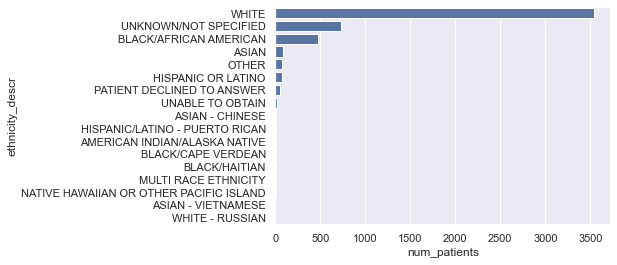

In [52]:
sns.barplot(y="ethnicity_descr", x="num_patients", data=ethnicity.sort_values("num_patients", ascending=False), color="C0")

### 1.2 In-hospital mortality by race
Let's compare the **proportion** of patients who died in the hospital by race. We'll limit to the 4 highest frequency races so the denominators aren't too small:
```
("WHITE", "BLACK/AFRICAN AMERICAN", "ASIAN", "HISPANIC OR LATINO")
```
1. First, write a query which returns a **patient-level** dataframe (meaning one row per patient) containing the race/ethnicity and whether a patient died in the hospital. Filter to patients in the racial groups above.
2. Then group by race/ethnicity (either in pandas or SQL) and calculate the proportion of patients in each category who died in the hospital.
3. Finally, plot the proportions as a barplot.

In [75]:
# RUN CELL TO SEE HINT
hint_mortality_by_race

In [76]:
query = """
SELECT DISTINCT
    p.subject_id,
    d.ethnicity_descr,
    p.hospital_expire_flg
FROM d_patients p
    INNER JOIN demographic_detail d
        ON p.subject_id = d.subject_id
WHERE ethnicity_descr IN ("WHITE", "BLACK/AFRICAN AMERICAN", "ASIAN", "HISPANIC OR LATINO")
"""
df = pd.read_sql(query, conn)

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [77]:
df["in_hospital_mortality"] = (df["hospital_expire_flg"] == "Y").astype(int)

<AxesSubplot:ylabel='ethnicity_descr'>

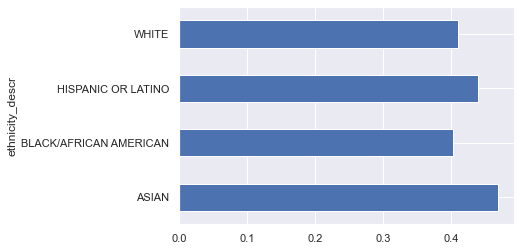

In [78]:
props = df.groupby("ethnicity_descr")["in_hospital_mortality"].mean()
props.plot.barh()

# 2. Hematocrit
A hematocrit test measures the percentage of red blood cells in a patient's blood.

1. Select a **the first 20,000 rows** of labs which contain results for the following test. Save the resulting dataframe as a variable called `hemat`.
    - **Loinc Code**: 20570-8	
    - **LOINC Description**: Hematocrit [Volume Fraction] of Blood<br>

2. Fill the **NaN** values in the **"flag"** column with **"Normal"**. You can either do this with SQL using the `coalesce` function, or with Pandas using the `fillna` method. How many rows have normal vs. abnormal values?
3. Generate descriptive statistics for the lab results in the column **"valuenum"**, stratified by **flag**
4. Create a plot which show the distribution of test result values within each stratum of **flag**

In [113]:
QuizHint(hints=[
    widgets.HTML("""Your output should look something like this: </br>
    <img src="./media/hint_hematocrit_dist.png" width="50%"></img>""")
])

In [ ]:
# RUN CELL TO SEE QUIZ
quiz_hematocrit_normal

In [102]:
query = """
SELECT 
    subject_id,
    valuenum,
    COALESCE(flag, 'Normal') AS flag
FROM labevents
    INNER JOIN d_labitems
        ON labevents.itemid = d_labitems.itemid
WHERE loinc_code = '20570-8'
LIMIT 20000;
"""
hemat = pd.read_sql(query, conn)
hemat.head()

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subject_id,valuenum,flag
0,37,30.0,Normal
1,12,35.0,Normal
2,12,32.0,Normal
3,12,32.0,Normal
4,12,32.0,Normal


In [103]:
hemat.groupby("flag").size()

flag
Normal      11862
abnormal     8088
delta          50
dtype: int64

In [107]:
hemat.groupby("flag")["valuenum"].describe()

,count,mean,std,min,25%,50%,75%,max
flag,,,,,,,,
Normal,11862.0,31.721708,6.197369,0.0,28.000,32.00,36.00,129.0
abnormal,8088.0,30.392050,3.970016,10.0,27.800,30.30,33.00,56.3
delta,50.0,42.228000,3.596316,35.8,39.675,41.95,44.55,48.6


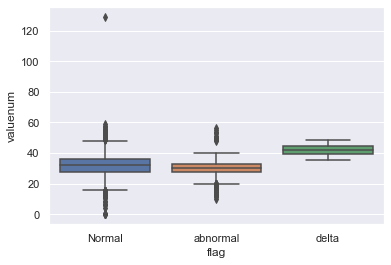

In [109]:
sns.boxplot(x="flag", y="valuenum", data=hemat);

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='valuenum', ylabel='Density'>

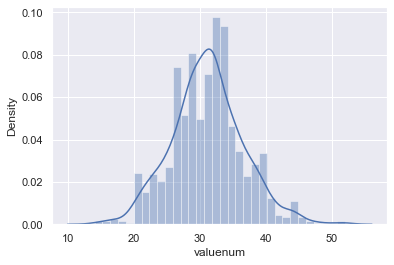

In [83]:
sns.distplot(hemat["valuenum"])

# 3. ABI
The **ankle-brachial index test** compares the blood pressure measured at your ankle with the blood pressure measured at your arm. It is used to check for peripheral artery disease. A low ABI can indicate a blocking in your arteries. [[Mayo Clinic]](https://www.mayoclinic.org/tests-procedures/ankle-brachial-index/about/pac-20392934) 

Let's analyze this test and see what the distribution of values look like. In MIMIC, the following chartevents itemids indicate ABI measurements:

```
(2, 3, 4, 5)
```

## Instructions
1. Join the tables `d_chartitems` and `chartevents`. Filter the results to rows which measure ABI values using the `itemid`s given above. Select all rows (there won't be too many). Assign the results to `abi`
2. Drop rows which are missing `value1num`
3. Calculate the min, max, and mean values of `value1num`
4. Generate a histogram. Change the number of bins to more clearly show the detail of the distribution using the `bins` argument 

In [142]:
QuizHint(hints=[
    widgets.HTML("""We did something similar in <a href="./03-Labs-and-Vitals.ipynb" target="_blank">03-Labs-and-Vitals</a>
    with systolic and diastolic blood pressure."""),
                widgets.HTML("""In a histogram, a larger number of bins shows more detail, a smaller number shows less. 
                Here are two examples of histograms for abi with different numbers of bins:</br>
                <img src="./media/hint_abi_hist.png" width="50%"></img>""")
])

In [130]:
# RUN CELL TO SEE QUIZ
quiz_count_abi

In [123]:
query = """
SELECT *
FROM mimic2.chartevents
    INNER JOIN d_chartitems ON chartevents.itemid = d_chartitems.itemid
WHERE chartevents.itemid IN (2, 3, 4, 5);
"""
abi = pd.read_sql(query, conn)
abi.head()

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,subject_id,icustay_id,itemid,charttime,elemid,realtime,cgid,cuid,value1,value1num,value1uom,value2,value2num,value2uom,resultstatus,stopped,itemid,label,category,description
0,21,23.0,2,3138-10-31 15:00:00,0,3138-10-31 15:00:00,-1,1,None,NaN,None,None,NaN,None,None,D/C'd,2,ABI (L),None,None
1,1308,1611.0,2,2999-12-03 18:00:00,0,2999-12-03 18:26:00,6237,1,.93181800842285156,0.931818,.,None,NaN,None,None,NotStopd,2,ABI (L),None,None
2,1308,1611.0,2,2999-12-03 22:00:00,0,2999-12-03 22:00:00,-1,1,None,NaN,None,None,NaN,None,None,D/C'd,2,ABI (L),None,None
3,1501,39229.0,2,3477-12-10 06:00:00,0,3477-12-10 06:14:00,2049,1,.49090901017189026,0.490909,.,None,NaN,None,None,NotStopd,2,ABI (L),None,None
4,1501,39229.0,2,3477-12-10 18:00:00,0,3477-12-10 17:53:00,2029,1,.71428602933883667,0.714286,.,None,NaN,None,None,NotStopd,2,ABI (L),None,None


In [124]:
len(abi)

364

In [126]:
abi = abi.dropna(subset="value1num")

In [127]:
len(abi)

189

In [120]:
abi["value1num"].describe()

count    189.000000
mean      49.541031
std       50.128913
min        0.000000
25%        0.806122
50%       50.000000
75%       99.000000
max      140.000000
Name: value1num, dtype: float64

/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value1num', ylabel='Density'>

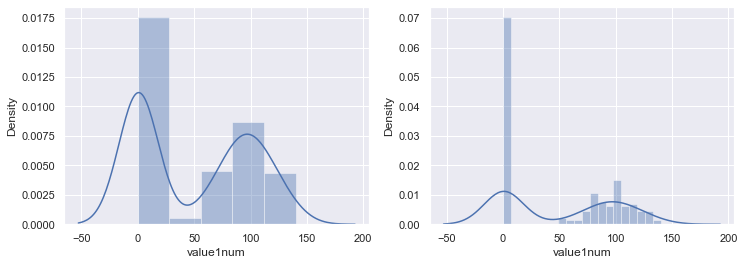

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(abi["value1num"], ax=ax1)
sns.distplot(abi["value1num"], bins=20, ax=ax2)

## 4 (Advanced) Comparing prevalence by race/ethnicity
Let's say we wanted to compare the prevalence of certain diseases among patients who were black/african american and those who were white. Calculate the proportion out of all patients in those racial categories who have the following ICD-9 codes:

- `401.9`: Unspecified essential hypertension
- `428.0`: Congestive heart failure unspecified
- `427.31`: Atrial fibrillation
- `403.91`: Hypertensive chronic kidney disease with stage 5 chronic kidney disease or end stage renal disease
- `584.9`: Acute kidney failure, unspecified


In [147]:
QuizHint(hints=[
    widgets.HTML("""To do this, you'll need to use two different subqueries (one to get the total counts by ethnicity,
    another to get the counts of each disease by ethnicity) and join them together."""),
    widgets.HTML("""The first subquery should group by ethnicity_descr, the second should group by ethnicity_descr and ICD-9 code."""),
    widgets.HTML("""Here is a visualization showing the results: </br>
    <img src="./media/hint_prop_disease_by_race.png" width="50%"></img>""")
])

In [146]:
# RUN CELL TO SEE QUIZ
quiz_dx_prevalence_by_race

In [44]:
query = """
SELECT
	e.ethnicity_descr 
    ,code
    ,n_patients
    ,n_diseased
    ,n_diseased / n_patients prevalence
FROM (
SELECT 
    ethnicity_descr,
    COUNT(1) AS n_patients
FROM demographic_detail 
WHERE ethnicity_descr IN ('BLACK/AFRICAN AMERICAN', 'WHITE')
GROUP BY ethnicity_descr
) e
INNER JOIN (
SELECT d.ethnicity_descr, i.code, COUNT(1) n_diseased
FROM icd9 i
INNER JOIN demographic_detail d
	ON i.hadm_id = d.hadm_id
WHERE code IN ('401.9', '428.0', '427.31', '403.91', '584.9')
GROUP BY ethnicity_descr, i.code
) icd
	ON e.ethnicity_descr = icd.ethnicity_descr
ORDER BY n_diseased / n_patients desc
;
"""


/Users/alecchapman/opt/miniconda3/envs/phs/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


<AxesSubplot:xlabel='code', ylabel='prevalence'>

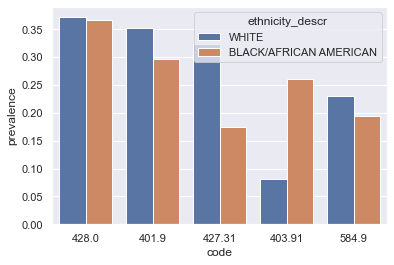

In [47]:
dx_by_race = pd.read_sql(query, conn)
sns.barplot(x="code", y="prevalence", hue="ethnicity_descr", data=dx_by_race)